## Ekstraksi Perilaku Pengguna

### Instalisasi Library yang Dibutuhkan

Melakukan instalisasi library yang dibutuhkan dalam proses ekstraksi perilaku pengguna

In [ ]:
#!pip install karateclub

In [ ]:
#!pip install tslearn

Meelakukan koneksi data ke Google Drive untuk mengakses resources

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Melakukan import path untuk akses resources secara spesifik di Google Drive

In [ ]:
import os, sys

sys.path.append('/content/drive/MyDrive/Thesis/libraries')
os.chdir('/content/drive/MyDrive/Thesis/libraries')

### Import Library yang Dibutuhkan

Melakukan import library yang dibutuhkan untuk proses ekstraksi perilaku pengguna

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from networkx.algorithms import community
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from karateclub import DeepWalk
from sklearn.cluster import KMeans
from dpca import DensityPeakCluster
from sklearn.cluster import DBSCAN

## Tahapan Ektsraksi Perilaku Pengguna

### 1. Mekanisme Ekstraksi Perilaku Pengguna berdasarkan  Jaringan Graf

Melakukan import data pada periode sebelum dan setelah COVID-19

In [ ]:
# import dataset
#before covid
#data_df = pd.read_csv("/content/drive/MyDrive/Thesis/output/6_04042022_before_covid_pearson_result.csv")

#after covid
data_df = pd.read_csv("/content/drive/MyDrive/Thesis/output/6_04042022_after_covid_pearson_result.csv")

### 2. Pemetaan Graf

Melakukan pemetaan graf berdasarkan hasil korelasi cramer's V dari proses sbeleumnya

#### 2.1 Konstruksi Jaringan Graf

Melakukan import data graf

In [ ]:
#Memilih kolom yang dibutuhkan untuk konstruksi graf
selected_df = data_df[["from_user_alias", "to_user_alias", "relation_type"]]

# create Graph
G = nx.from_pandas_edgelist(selected_df, "from_user_alias", "to_user_alias", ["relation_type"],  create_using=nx.Graph())
#print(len(G))

#menghapus node graf yang terisolasi
G.remove_nodes_from(list(nx.isolates(G)))

Menyimpan hasil pemetaan graf awal dari pengguna

In [ ]:
#before covid
#nx.write_graphml(G, "/content/drive/MyDrive/Thesis/output/7_04042022_noncovid_graph_data_before_deepwalk.graphml")

#after covid
#nx.write_graphml(G, "/content/drive/MyDrive/Thesis/output/7_24032022_covid_graph_data_before_deepwalk.graphml")

In [ ]:
#graf_clustering_result = pd.read_csv('/content/drive/MyDrive/Thesis/output/7_06042022_before_covid_final_user_behavior_result.csv')
#graf_clustering_result = pd.read_csv('/content/drive/MyDrive/Thesis/output/7_06042022_after_covid_final_user_behavior_result.csv')
#graf_clustering_result = graf_clustering_result.loc[:, ~graf_clustering_result.columns.str.contains('^Unnamed')]

In [ ]:
#mapping = {}

#for node in G:

#    data = graf_clustering_result[graf_clustering_result['user_alias'] == int(node)]
#    node_name = data['username'][data['username'].index[0]]

    #mapping = {'{}'.format(node): node_name}
    #mapping[node] = node_name
    #print(mapping)
    #G = nx.relabel_nodes(G, mapping)

Menentukan degree rank untuk mengurangi kompleksitas visualisasi data graf

In [ ]:
def trim_degrees(graph, degree):
    final_graph = G.copy()
    
    data = nx.degree(final_graph)
    list_final_graph = list(final_graph.nodes)
    
    for node in list_final_graph:
        if data[node]<=degree: 
            final_graph.remove_node(node)
            
    return final_graph

In [ ]:
#G = trim_degrees(G, 5)
#len(G)

Melakukan kustomisasi warna edede dan node untuk mempermudah analisis jaringan graf

In [ ]:
def change_edge_color(edge):
    #set_color = '#808080'
    
    if G[edge[0]][edge[1]]['relation_type'] == "topic":
        set_color = '#DCDCDC'
    #elif cluster_number == 13:
    elif G[edge[0]][edge[1]]['relation_type'] == "emotion":
        set_color = '#808080'
        
    return set_color

def change_node_color(node):
    set_color = '#B0E0E6'

    return set_color

Menampilkan hasil pemetaan graf

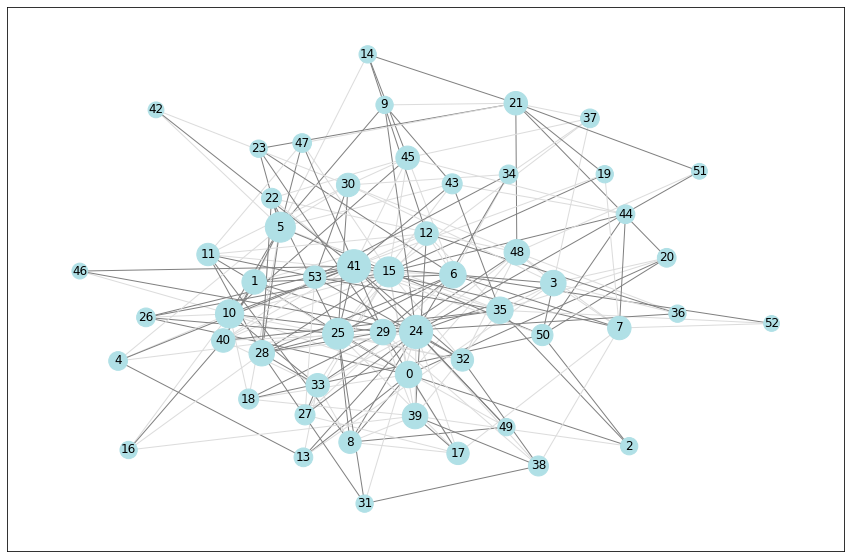

In [ ]:
plt.figure(figsize=(15,10))

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(G)
pos_nodes = nudge(pos, 0, 0.04)
degrees = nx.degree(G)
node_size = [(degrees[v] + 2) * 50 for v in G.nodes()]
#betCent = nx.betweenness_centrality(graph_before_deepwalk, normalized=False, endpoints=True)
#node_size =  [v * 50 for v in betCent.values()]
node_color = [change_node_color(node) for node in G]
edge_color = [change_edge_color(edge) for edge in G.edges()]

nx.draw_networkx(G,  
                 node_size=node_size,
                 node_color=node_color, 
                 edge_color=edge_color,
                 cmap=plt.cm.PiYG, 
                 pos=pos_nodes,
                 with_labels=True,
                 linewidths=1)

#plt.savefig('/content/drive/MyDrive/Thesis/output/graph_before_deepwalk_before_covid_300.png', dpi=300)
#plt.savefig('/content/drive/MyDrive/Thesis/output/graph_before_deepwalk_after_covid_300.png', dpi=300)

#### 2.1. Evaluasi Jaringan Graf

Melakukan evaluasi jaringan graf untuk mengukur seberapa baik performa graf dalam membagi kelompok dalam jaringan menggunakan metode Naive Greedy Modularity

In [ ]:
naive_greedy = community.naive_greedy_modularity_communities(G)
naive_greedy

[frozenset({1, 4, 5, 9, 11, 12, 14, 22, 25, 30, 35, 40, 41, 42, 43, 45, 53}),
 frozenset({3, 8, 13, 24, 28, 29, 31, 32, 33, 36, 38, 48, 49, 51}),
 frozenset({0, 2, 10, 15, 16, 18, 20, 26, 39, 44, 46, 50}),
 frozenset({6, 7, 17, 19, 21, 23, 27, 34, 37, 47, 52})]

Mengevaluasi hasil pengelompokan performa graf

In [ ]:
modularity_score = community.modularity(G, naive_greedy)
print('Modularity Score: ', round(modularity_score, 2))

performance_score = community.performance(G, naive_greedy)
print('Performance Score: ', round(performance_score, 2))

coverage_score = community.coverage(G, naive_greedy)
print('Coverage Score: ', round(coverage_score, 2))

Modularity Score:  0.24
Performance Score:  0.76
Coverage Score:  0.51


#### 2.3 Pemetaan Perilaku Pengguna dengan Algoritme DeepWalk network Embeddings

Melakukan inisialisasi parameter pada algoritme DeepWalk

In [ ]:
# train model and generate embedding
model = DeepWalk(walk_length=100, dimensions=64, window_size=5)
model.fit(G)
embedding = model.get_embedding()

Melakukan pemetaan hasil pemodelan DeepWalk

In [ ]:
# print Embedding shape
print(embedding.shape)
nodes =list(range(len(G)))

(54, 64)


In [ ]:
X = embedding[nodes]

In [ ]:
#nx.write_graphml(G, "/content/drive/MyDrive/Thesis/output/7_04042022_noncovid_graph_data_after_deepwalk.graphml")
#nx.write_graphml(G, "/content/drive/MyDrive/Thesis/output/7_04042022_covid_graph_data_after_deepwalk.graphml")

In [ ]:
#plt.figure(figsize=(15,10))
#pos = nx.spring_layout(G)
#degrees = nx.degree(G)

#nx.draw_networkx(G, pos=pos, cmap=plt.cm.PiYG, with_labels=True)

#### 2.4 Klasterisasi Perilaku Pengguna

**2.4.1 Reduksi Dimensi Data**

Melakukan reduksi data dengan PCA dan TSNE

In [ ]:
#X_scaler = StandardScaler().fit_transform(X)

#pca = PCA(n_components=2)
#pca_out= pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=0)
pca_out = tsne.fit_transform(X)

#pca_out = X

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


**2.4.2 Melakukan Pemodelan Algoritme DPCA**

In [ ]:
#dpca_model = DensityPeakCluster(density_threshold=0.01, distance_threshold=1, anormal=False)
dpca_model = DensityPeakCluster(anormal=False)

# fit model
dpca_model.fit(X)

dpca_labels = dpca_model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dpca_labels)) - (1 if -1 in dpca_labels else 0)
n_noise_ = list(dpca_labels).count(-1)

print("Estimated number of clusters: ", n_clusters_)
print("Estimated number of noise points: ", n_noise_)

print("Silhouette Score: %0.2f" % metrics.silhouette_score(X, dpca_labels))
print("Calinski Harabasz Score: %0.2f" % metrics.calinski_harabasz_score(X, dpca_labels))
print("Davies Bouldin Score: %0.2f" % metrics.davies_bouldin_score(X, dpca_labels))

**2.4.3 Melakukan Pemodelan Algoritme K-Means**

In [ ]:
for i in range(2, 7):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(pca_out)

    kmeans_labels = kmeans_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(kmeans_labels)) - (1 if -1 in kmeans_labels else 0)
    n_noise_ = list(kmeans_labels).count(-1)

    print("Klaster : {}".format(i))
    print("Estimated number of clusters: ", n_clusters_)
    print("Estimated number of noise points: ", n_noise_)
    print("Silhouette Score: %0.2f" % metrics.silhouette_score(X, kmeans_labels))
    print("Calinski Harabasz Score: %0.2f" % metrics.calinski_harabasz_score(X, kmeans_labels))
    print("Davies Bouldin Score: %0.2f" % metrics.davies_bouldin_score(X, kmeans_labels))
    print('')

Klaster : 2
Estimated number of clusters:  2
Estimated number of noise points:  0
Silhouette Score: 0.18
Calinski Harabasz Score: 17.14
Davies Bouldin Score: 1.61

Klaster : 3
Estimated number of clusters:  3
Estimated number of noise points:  0
Silhouette Score: 0.13
Calinski Harabasz Score: 14.89
Davies Bouldin Score: 1.72

Klaster : 4
Estimated number of clusters:  4
Estimated number of noise points:  0
Silhouette Score: 0.16
Calinski Harabasz Score: 16.39
Davies Bouldin Score: 1.66

Klaster : 5
Estimated number of clusters:  5
Estimated number of noise points:  0
Silhouette Score: 0.12
Calinski Harabasz Score: 15.38
Davies Bouldin Score: 1.76

Klaster : 6
Estimated number of clusters:  6
Estimated number of noise points:  0
Silhouette Score: 0.09
Calinski Harabasz Score: 12.87
Davies Bouldin Score: 1.82



**2.4.4 Melakukan Pemodelan dengan Algoritme K-Shape**

In [ ]:
from tslearn.clustering import KShape

for i in range(2, 7):
    kshape_model = KShape(n_clusters=i, random_state=0).fit(pca_out)

    kshape_labels = kshape_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(kshape_labels)) - (1 if -1 in kmeans_labels else 0)
    n_noise_ = list(kshape_labels).count(-1)

    print("Klaster : {}".format(i))
    print("Estimated number of clusters: ", n_clusters_)
    print("Estimated number of noise points: ", n_noise_)
    print("Silhouette Score: %0.2f" % metrics.silhouette_score(X, kshape_labels))
    print("Calinski Harabasz Score: %0.2f" % metrics.calinski_harabasz_score(X, kshape_labels))
    print("Davies Bouldin Score: %0.2f" % metrics.davies_bouldin_score(X, kshape_labels))
    print('')

Klaster : 2
Estimated number of clusters:  2
Estimated number of noise points:  0
Silhouette Score: 0.08
Calinski Harabasz Score: 7.26
Davies Bouldin Score: 2.33

Klaster : 3
Estimated number of clusters:  2
Estimated number of noise points:  0
Silhouette Score: 0.08
Calinski Harabasz Score: 7.26
Davies Bouldin Score: 2.33

Klaster : 4
Estimated number of clusters:  2
Estimated number of noise points:  0
Silhouette Score: 0.08
Calinski Harabasz Score: 7.26
Davies Bouldin Score: 2.33

Klaster : 5
Estimated number of clusters:  2
Estimated number of noise points:  0
Silhouette Score: 0.08
Calinski Harabasz Score: 7.26
Davies Bouldin Score: 2.33

Klaster : 6
Estimated number of clusters:  2
Estimated number of noise points:  0
Silhouette Score: 0.08
Calinski Harabasz Score: 7.26
Davies Bouldin Score: 2.33



**2.4.5 Konversi Format dan Penyimpanan Data**

In [ ]:
final_data_df = data_df.copy()

In [ ]:
final_data_df = final_data_df[['from_user', 'from_user_alias', 'from_user_tweet_number']]
final_data_df = final_data_df.rename(columns={'from_user': 'username', 'from_user_alias': 'user_alias', 'from_user_tweet_number': 'tweet_count'})
final_data_df = final_data_df.drop_duplicates()

In [ ]:
users_list = list(G.nodes)

final_user_list = []

for index, user in final_data_df.iterrows():
  if user['user_alias'] in users_list:
    final_user_list.append([user['username'], user['user_alias']])

In [ ]:
final_user_df = pd.DataFrame(final_user_list, columns=['username', 'user_alias'])
final_user_df = final_user_df.drop_duplicates()
final_user_df['cluster'] = dpca_labels

In [ ]:
#before covid
#final_user_df.to_csv('/content/drive/MyDrive/Thesis/output/7_06042022_before_covid_final_user_behavior_result.csv')

#after covid
final_user_df.to_csv('/content/drive/MyDrive/Thesis/output/7_06042022_after_covid_final_user_behavior_result.csv')

#### 5. Visualisasi Hasil Data

**5.1 Distribusi Perilaku Pengguna berdasarkan Graf Jaringan**

Melakukan plotting data untuk pemetaan node dalam ruang vektor

In [ ]:
# plot nodes graph
def plot_nodes(node_no):
    X = embedding[node_no]
      
    pca = PCA(n_components=2)
    pca_out= pca.fit_transform(X)

    i = 3  

    kmeans = KMeans(n_clusters=i, random_state=0).fit(pca_out)    
      
    plt.figure(figsize=(10,5))
    plt.scatter(pca_out[:, 0], pca_out[:, 1])
    for i, node in enumerate(node_no):
        plt.annotate(node, (pca_out[i, 0], pca_out[i, 1]))
    
    centroids = kmeans.cluster_centers_
    # Plot the centroids as a red X
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', color='r')

    #for i in centroids:
        #print(np.max(metrics.pairwise_distances(i, pca_out)))
    #    plt.gca().add_artist(plt.Circle(i, np.max(metrics.pairwise_distances(i, pca_out)), fill=False))

    #for ind,i in enumerate(centroids):
    #  i = i.reshape(1, -1)
    #  class_inds = np.where(kmeans.labels_ == ind)[0]
    #  max_dist=np.max(metrics.pairwise_distances(i, pca_out[class_inds]))
    #  plt.gca().add_artist(plt.Circle(i, max_dist, fill=False))
  
plot_nodes(nodes)

**5.2 Visualisasi Hasil Klasterisasi DPCA**

Dari hasil perbandingan algoritme DPCA, K-Means dan K-Shape, maka didapatkan algoritme yang memiliki hasil paling baik adalah DPCA. Oleh karena itu, maka visualisasi node hasil klasterisasi perilaku dipilih dberdasarkan hasil pemodelan DPCA

In [ ]:
# plot cluster
dpca_model.plot("label", title='behavior similarity _')

**5.3 Visualisasi Hasil K-Means**

Sebagai pembanding, dilakukan visualisasi hasil dari pemodelan K-Means.

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1)
fig.update_layout(
    title="Hasil PCA Periode sebelum COVID-19",
    autosize=False,
    width=600,
    height=500,)
fig.show()